## Python script to clip data to shapefile

> **Author**: Sunny Bak Hospital from PolarWatch  
> **Date Created**: 06.06.2024  
> **Email**: [sun.bak-hospital@noaa.gov](mailto:sun.bak-hospital@noaa.gov)

### Description

This notebook demonstrates the process of clipping projected data with a shapefile in a different project.  

__data source__ 
A netCDF file generated from load_multiple_file_memory.ipynb will be used. The nc file is a subset of data from the source.

source: https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/1km/


In [43]:
# Load packages
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from pathlib import Path
import rioxarray
from shapely.geometry import mapping

In [8]:
shapefile_path = 'resources/World_Lakes_shapes/World_Lakes.shp'
lakes_shp = gpd.read_file(shapefile_path)


In [25]:
# Get Iliamna Lake shape from the World lakes shapefile (Hylak_id = 31)
iliamna_shp = lakes_shp[lakes_shp['Hylak_id'] == 31]


In [26]:
# Examine crs
iliamna_shp.crs


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

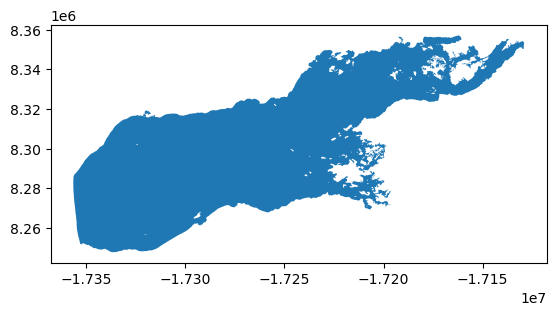

In [27]:
# Visualize the lake 
iliamna_shp.plot()

In [36]:
# from PolarWatch functional utilities

def set_geo_specs(dat: xr.DataArray, xdim: str, ydim: str, crs: str) -> xr.DataArray:
    """Update the spatial dimensions and coordinate reference system (CRS) of an xarray DataArray.

    Args:
        dat (xr.DataArray): The data array to modify.
        xdim (str): Name of the dimension representing the x-coordinate.
        ydim (str): Name of the dimension representing the y-coordinate.
        crs (str): String representation of the coordinate reference system to assign.

    Returns:
        xr.DataArray: The updated data array with specified spatial dimensions and CRS.
    """
    dat = dat.rio.set_spatial_dims(x_dim=xdim, y_dim=ydim)
    dat = dat.rio.write_crs(crs)
    return dat


def clip_data_to_shapefile(data_array: xr.DataArray, shapefile_geom, crs: str):
    """Clip data array to the specified shapefile geometry with CRS.
    
    Args:
        data_array (xr.DataArray): The data array to modify.
        shapefile_geom : Shapefile geometry.
        crs (str): CRS of the data.

    Returns:
        xr.DataArray: The updated data array with specified spatial dimensions and CRS.  
    
    """
    try:
        clipped_data = data_array.rio.clip(shapefile_geom.apply(mapping), crs)
        print("Clipping successful")
        return clipped_data
    except Exception as e:
        print(f"Error during clipping: {e}")
        raise

def transform_shapes(shp: gpd.GeoDataFrame, crs:str):
    # Transform projection to Polar Stereographic Projection
    try:
        shp_proj_transformed = shp.to_crs(crs)
        #logging.info("Projection transformed to EPSG:3413.")
        return shp_proj_transformed
    except Exception as e:
        #logging.error(f"Error transforming CRS: {e}")
        raise

In [28]:
# load ims sea ice data from a file 
ds = xr.open_dataset("ims1k_2023.nc")

In [58]:
# examine dataset
ds 


<xarray.Dataset> Size: 234MB
Dimensions:             (time: 365, y: 400, x: 400)
Coordinates:
    projection          int64 8B 0
  * x                   (x) float32 2kB -3.398e+06 -3.396e+06 ... -2.998e+06
  * y                   (y) float32 2kB -9.975e+05 -9.965e+05 ... -5.985e+05
  * time                (time) datetime64[ns] 3kB 2023-01-01 ... 2023-12-31
Data variables:
    IMS_Surface_Values  (time, y, x) float32 234MB ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    01 January 2023 00:35Z: NetCDF file generated...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

In [47]:
# Set crs_project as the data crs (based on the metadata)
crs_project = "+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257"

# Set data crs
ds = set_geo_specs(ds, xdim="x", ydim="y", crs=crs_project)

# Transform the shape into the data crs
iliamna_transformed = transform_shapes(iliamna_shp, crs_project)


In [48]:
# Examine lake shape crs
iliamna_transformed.crs

<Projected CRS: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 + ...>
Name: unknown
Axis Info [cartesian]:
- E[south]: Easting (metre)
- N[south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Polar Stereographic (variant B)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

<Axes: >

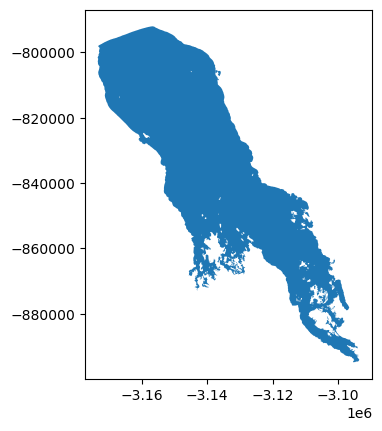

In [39]:
# Visualized transformed iliamna shape
iliamna_transformed.plot()

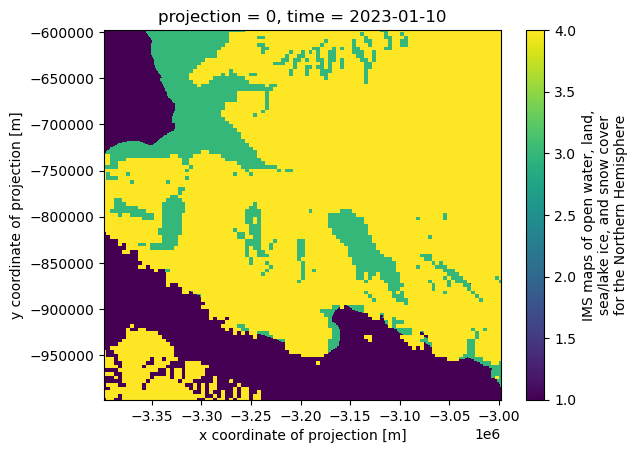

In [49]:
# Visually compare the geometry to that of the dataset
ds.isel(time=9)["IMS_Surface_Values"].plot()

In [52]:
# Clip data to the shape
ds_clipped = clip_data_to_shapefile(ds, iliamna_transformed.geometry, iliamna_transformed.crs)

Clipping successful


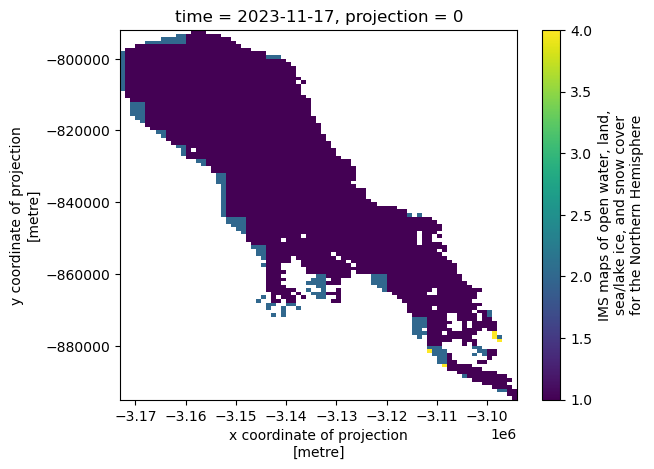

In [57]:
# Visualized clipped data
ds_clipped.isel(time=320)["IMS_Surface_Values"].plot()